In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
p = 'output/2021_Feb_10_19_55_56_PAMBUH/'

In [3]:
import os
import sys
os.chdir('..')
# sys.path.append(p  + 'src')
sys.path.append('src')

In [4]:
from pathlib import Path
from PIL import Image
from functools import partial

from tqdm.auto import tqdm
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import albumentations as albu
from tqdm.notebook import tqdm
import _data
import augs
import callbacks
import sampler
import model as nn_model
from config import cfg, cfg_init
from postprocessing import read_and_process_img, postprocess_test_folder, _plot_img
from sampler import get_basics_rasterio

import  matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# datasets = data.build_datasets(cfg)
# dls = data.build_dataloaders(cfg, datasets, pin=True, drop_last=False)
# tdl = dls['TRAIN']
# xb,yb = next(iter(tdl))
# xb.shape, yb.shape

# s = sampler.tif_block_read('./input/hm/test/b2dc8411c.tiff')
# _,_,img = next(iter(s))
# img.shape, img.dtype

In [6]:
from utils import get_tiff_block

In [7]:
def parse_model_path(p):
    name = str(p.name)
    epoch = name.split('_')[0]
    return int(epoch[1:])

def get_last_model(src):
    # assumes that model name is of type e500_blabla.pth, sorted by epoch #500
    models = list(Path(src).glob('*.pth'))
    res = []
    for i, m in enumerate(models):
        epoch = parse_model_path(m)
        #print(m, epoch)
        
        res.append([i,epoch])
    idx = sorted(res, key=lambda x: -x[1])[0][0]
    return models[idx]

def rescale(batch_img, scale): return F.interpolate(batch_img, scale_factor=(scale, scale))

def preprocess_image(cfg, img):
    train_trans = augs.get_aug('light', cfg.TRANSFORMERS)
    transform = train_trans.transforms.transforms[-1]
    #print(transform)
    #transform = albu.Compose([albu.Normalize(mean=cfg.TRANSFORMERS.MEAN, std=cfg.TRANSFORMERS.STD)])
    ch, H,W, dtype = *img.shape, img.dtype
    assert ch==3
    assert dtype==np.uint8, dtype
    img = img.transpose(1,2,0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (W//2, H//2))
    return transform(image=img)['image']

device = 'cuda:2'

def _infer_func(imgs, cfg, model):
    batch = []
    for img in imgs:
        batch.append(preprocess_image(cfg, img))
    
    batch = torch.stack(batch,axis=0)
    if torch.cuda.is_available():
        batch = batch.to(device)
    with torch.no_grad():
        res = torch.sigmoid(model(batch))
    res = rescale(res, 2)
    return res

def get_infer_func(p):
    cfg_init(p + 'cfg.yaml')
    cfg['PARALLEL']['DDP'] = False
    cfg['DATA']['TRAIN']['PRELOAD'] = False
        
    model_path = get_last_model(p + 'models')
    m = nn_model.load_model(cfg, str(model_path))
    
    if torch.cuda.is_available():
        m = m.to(device)
    return partial(_infer_func, cfg=cfg, model=m)

In [8]:
foo = get_infer_func(p)

In [9]:
src_folder = '/mnt/storage/HuBMAP/test/'
img_name = next(Path(src_folder).glob('*.tiff'))
print(img_name)

/mnt/storage/HuBMAP/test/b9a3865fc.tiff


In [21]:
mask = read_and_process_img(img_name, foo, 2048, 2000)
mask.shape

31295 40429


rows:   0%|          | 0/16 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

columns:   0%|          | 0/21 [00:00<?, ?it/s]

(31295, 40429)

(31295, 40429)


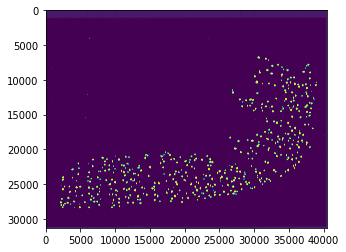

In [22]:
_plot_img(mask)

In [ ]:
postprocess_test_folder(foo, src_folder, './output')

In [ ]:
def crop(src, y,x,h,w): return src[..., y:y+h, x:x+w]
def paste(src, block, y,x,h,w):  src[..., y:y+h, x:x+w] = block
def get_shift_center(block, h,w): return block.shape[1]//2 -h//2, block.shape[2]//2 -w//2
def pad_block(y,x,h,w, pad): return np.array([y-pad, x-pad, h+pad, w+pad])

def pad_image(img, pad):
    h, w = img.shape[1], img.shape[2]
    img_pad = np.zeros((3, h+2*pad, w+2*pad)).astype(img.dtype)
    paste(img_pad, img, pad,pad, h, w)
    return img_pad

def generate_block_coords(H, W, block_size=(128,128)):
    h,w = block_size
    nXBlocks = (int)((H + h - 1) / h)
    nYBlocks = (int)((W + w - 1) / w)
    nXValid, nYValid = h, w
    for X in range(nXBlocks):
        if X == nXBlocks - 1: nXValid = W - X * h
        cx = X * h
        nYValid = w
        for Y in range(nYBlocks):
            if Y == nYBlocks - 1: nYValid = H - Y *w
            cy = Y * w
            yield cy, cx, nYValid, nXValid

def infer_image(img, do_inference, block_size=512, pad=16):
    img_pad, mask = pad_image(img, pad), np.zeros_like(img).astype(np.float16)
    print('padded')
    cds = list(generate_block_coords(img.shape[1], img.shape[2], block_size=(block_size,block_size)))
    
    for block in tqdm(cds):
        padded_block = pad_block(*block, pad)
        part = crop(img_pad, *(pad + padded_block))
        part = do_inference(part)
        _,_,h,w = block
        y, x = get_shift_center(part, h,w)
        cc = crop(part, y, x, h, w)
        print(block, cc.shape, part.shape)
        paste(mask, cc, *block)
    
    return mask

In [ ]:
iimg = Image.open('input/cuts1024x05/imgs/0486052bb/000000.png')
img = np.array(iimg)
img = np.transpose(img, (2,0,1))
print(img.shape)

In [ ]:
def inf(img): return img/255.>.5

In [ ]:
mask = infer_image(img, inf, 128,16)
mask.max(), mask.min()

In [ ]:
plt.imshow(mask.astype(np.float32).transpose((1,2,0)))

In [ ]:
#Image.fromarray((255*mask).astype(np.uint8)).resize((512,512))

In [ ]:
import rasterio as rio

In [ ]:
img = rio.open('./input/hm/train/095bf7a1f.tiff').read()

In [ ]:
iimg = img[...,:9000,:5000]

In [ ]:
iimg.shape

In [ ]:
mask = infer_image(iimg, inf, 1024, 128)

In [ ]:
mask.shape

# Tests

## Sampler

In [ ]:
s = sampler.tif_block_read('./input/hm/test/b2dc8411c.tiff', block_size=(1024,1024))
s = iter(s)
_,_,img = next(s)
print(img.shape, img.dtype)

In [ ]:
Image.fromarray(img.transpose(1,2,0)).resize((256,256))

## Rasterio

In [10]:
import rasterio as rio

In [12]:
ds = rio.open(img_name)
ds.shape

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(31295, 40429)

In [13]:
x,y = 15750,16100
w,h=2048,2048
img = ds.read([1,2,3], window=((x,x+w),(y,y+h)))
print(img.shape, img.dtype)

(3, 2048, 2048) uint8


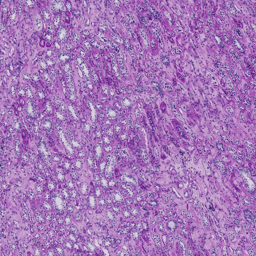

In [14]:
Image.fromarray(img.transpose(1,2,0)).resize((256,256))

In [21]:
%%timeit -n 10 -r 10
bb = foo([img])
bb.shape, bb.dtype, bb.max()

46.9 ms ± 4.09 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [ ]:
plt.imshow(bb[0][0])

In [ ]:
t = callbacks.denorm(dxb[0], mean=cfg.TRANSFORMERS.MEAN, std=cfg.TRANSFORMERS.STD).squeeze()
t = t.squeeze().permute(1,2,0).numpy()
t.shape

Image.fromarray((255.*t).astype(np.uint8))#.resize((512,512))